In [1]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot of the graph
from scipy.stats import mode
from scipy.stats import zscore
from scipy.stats import median_abs_deviation
import joblib
# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from helper import draw_confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

In [2]:
# Load Data
data = pd.read_csv("Data_Niki.csv")

# Dropping Unnecessary Rows and Columns
data = data.drop(index=[0,1])
columns_to_drop = ["Dont care", "Visualization", "Visualization.1", "Engineer classification", "Parameter name", "Unnamed: 9"]
param_name = data["Parameter name"]
data = data.drop(columns=columns_to_drop, errors='ignore')

data.head()

C:\Users\nxg15046\AppData\Local\Temp\2\ipykernel_23200\2889359007.py:2: DtypeWarning: Columns (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

,Engineer classification.1,Tranditional statistics,Unnamed: 7,Unnamed: 8,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,...,Unnamed: 385,Unnamed: 386,Unnamed: 387,Unnamed: 388,Unnamed: 389,Unnamed: 390,Unnamed: 391,Unnamed: 392,Unnamed: 393,Unnamed: 394
2,Need investigation,NaN,0,0,4.04E-02,3.99E-02,4.06E-02,4.05E-02,4.03E-02,4.07E-02,...,7.79E-04,5.99E-04,6.45E-04,5.29E-04,6.73E-04,4.30E-04,5.00E-04,6.28E-04,4.45E-04,4
3,Release,35.04718573,-0.02,0.02,1.56E-03,1.49E-03,1.38E-03,1.44E-03,1.38E-03,1.65E-03,...,1.05E-04,5.28E-05,1.41E-04,1.46E-04,1.42E-04,8.70E-05,5.25E-05,1.02E-04,6.45E-05,5
4,Release,1758.366676,0.495000005,0.50999999,5.03E-01,5.04E-01,5.02E-01,5.03E-01,5.03E-01,5.02E-01,...,1.24E-03,1.08E-03,1.19E-03,1.17E-03,1.01E-03,1.54E-03,1.15E-03,1.16E-03,1.27E-03,6
5,Need investigation (small margin),36.01323248,-0.001,0.003,2.65E-03,2.57E-03,2.64E-03,2.60E-03,2.65E-03,2.59E-03,...,6.60E-05,7.16E-05,8.95E-05,7.75E-05,6.88E-05,6.33E-05,5.26E-05,6.61E-05,7.53E-05,7
6,Release,1876.406716,0.986000001,1.014000058,1.00E+00,1.00E+00,1.00E+00,1.00E+00,1.00E+00,1.00E+00,...,2.28E-03,2.39E-03,2.28E-03,2.14E-03,1.87E-03,2.75E-03,2.08E-03,2.21E-03,2.65E-03,8


In [3]:
# Relabeling as Release or Investigate (0 or 1)
data['Engineer classification.1'] = (data['Engineer classification.1'] == 'Release').astype(int)

# Converting from String to Numerical
data = data.apply(pd.to_numeric, errors='coerce') 

# data.fillna(data.median(numeric_only=True), inplace=True)

In [4]:
# Obtaining Data with Purely Median and Std (nothing else)

columns_to_drop = ['Engineer classification.1', 'Tranditional statistics', 'Unnamed: 394'] # removed Unnamed: 7, Unnamed: 8
y = data['Engineer classification.1']
traditional_stat = data['Tranditional statistics']
# lower_lim = data['Unnamed: 7']
# upper_lim = data['Unnamed: 8']
only_med_std = data.drop(columns=columns_to_drop, axis=1)
only_med_std

,Unnamed: 7,Unnamed: 8,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,...,Unnamed: 384,Unnamed: 385,Unnamed: 386,Unnamed: 387,Unnamed: 388,Unnamed: 389,Unnamed: 390,Unnamed: 391,Unnamed: 392,Unnamed: 393
2,0.000000,0.000000,0.040400,0.039900,0.040600,0.040500,0.040300,0.040700,0.040100,0.040200,...,6.680000e-04,7.790000e-04,5.990000e-04,6.450000e-04,5.290000e-04,6.730000e-04,4.300000e-04,5.000000e-04,6.280000e-04,4.450000e-04
3,-0.020000,0.020000,0.001560,0.001490,0.001380,0.001440,0.001380,0.001650,0.001850,0.001460,...,1.920000e-04,1.050000e-04,5.280000e-05,1.410000e-04,1.460000e-04,1.420000e-04,8.700000e-05,5.250000e-05,1.020000e-04,6.450000e-05
4,0.495000,0.510000,0.503000,0.504000,0.502000,0.503000,0.503000,0.502000,0.503000,0.502000,...,1.040000e-03,1.240000e-03,1.080000e-03,1.190000e-03,1.170000e-03,1.010000e-03,1.540000e-03,1.150000e-03,1.160000e-03,1.270000e-03
5,-0.001000,0.003000,0.002650,0.002570,0.002640,0.002600,0.002650,0.002590,0.002640,0.002650,...,5.600000e-05,6.600000e-05,7.160000e-05,8.950000e-05,7.750000e-05,6.880000e-05,6.330000e-05,5.260000e-05,6.610000e-05,7.530000e-05
6,0.986000,1.014000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.080000e-03,2.280000e-03,2.390000e-03,2.280000e-03,2.140000e-03,1.870000e-03,2.750000e-03,2.080000e-03,2.210000e-03,2.650000e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,2.510000e-08,2.320000e-08,2.000000e-08,1.930000e-08,2.310000e-08,1.710000e-08,3.150000e-08,2.290000e-08,1.860000e-08,2.350000e-08
2669,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,1.880000e-08,1.960000e-08,2.200000e-08,6.540000e-08,2.200000e-08,2.600000e-08,4.710000e-08,1.880000e-08,1.900000e-08,2.290000e-08
2670,0.895500,0.904500,0.900000,0.899000,0.900000,0.899000,0.899000,0.900000,0.900000,0.900000,...,1.050000e-03,1.160000e-03,1.190000e-03,1.100000e-03,1.200000e-03,1.260000e-03,2.330000e-03,1.110000e-03,1.250000e-03,1.290000e-03
2671,0.895500,0.904500,0.901000,0.899000,0.900000,0.899000,0.900000,0.900000,0.899000,0.900000,...,1.210000e-03,1.200000e-03,1.160000e-03,5.580000e-03,1.210000e-03,1.030000e-03,5.390000e-03,1.280000e-03,1.050000e-03,1.240000e-03


In [ ]:
# Feature Augmentation

## Z-score for each median and standard deviation

# Extracting Median and Standard Deviation
med = only_med_std.iloc[:, 2:194] 
std = only_med_std.iloc[:, 194:386]

# Standardizing by Row
z_med = med.apply(zscore, axis=1)
z_med = pd.DataFrame(z_med.tolist(), index=med.index, columns=med.columns)
z_std = std.apply(zscore, axis=1)
z_std = pd.DataFrame(z_std.tolist(), index=std.index, columns=std.columns)

# Range (need to remove lower and upper limit)
z_med_min = z_med.min(axis=1)
z_std_min = z_std.min(axis=1)
z_med_max = z_med.max(axis=1)
z_std_max = z_std.max(axis=1)
z_med_range = z_med_max - z_med_min
z_std_range = z_std_max - z_std_min

## Inter-Quartile Range
Q1_med = z_med.quantile(0.25, axis=1)
Q3_med = z_med.quantile(0.75, axis=1)
z_med_iqr = Q3_med - Q1_med
Q1_std = z_std.quantile(0.25, axis=1)
Q3_std = z_med.quantile(0.75, axis=1)
z_std_iqr = Q3_std - Q1_std

## Median Absolute Deviation
z_med_mad = z_med.apply(median_abs_deviation, axis=1)
z_std_mad = z_std.apply(median_abs_deviation, axis=1)

## Skewness
med_skewness = med.skew(axis=1)
std_skewness = std.skew(axis=1)

## Kurtosis (Propensity for Outliers)
med_kurtosis = med.kurt(axis=1)
std_kurtosis = std.kurt(axis=1)

## Normalized Upper / Lower Bound
z_limit_med = z_med.iloc[:, 1] - z_med.iloc[:, 0]

## Range Divided by Bound
z_med_range_to_bound = z_med_range / z_limit_med

## IQR Divided by Bound
z_med_iqr_to_bound = z_med_iqr / z_limit_med

## Range vs IQR Ratio
eps = 1e-9
med_range_iqr_ratio = z_med_range / (z_med_iqr + eps)

## Experimental Feature
z_med_max = z_med.max(axis=1)
z_std_max = z_std.max(axis=1)
experimental = z_med_max * z_std_max

## Coefficient of Variation
eps = 1e-6
coeff_var = std / (med.abs() + eps) # avoid division by 0
mean_coeff_var = coeff_var.mean(axis=1)


In [6]:
x = pd.concat([z_med_range, z_std_range, z_med_iqr, z_std_iqr, z_med_mad, z_std_mad, med_skewness, std_skewness, med_kurtosis, std_kurtosis, med_range_iqr_ratio, experimental, mean_coeff_var, y], axis=1)

# Assigning New Column Names to Bypass Column Name Repeating Issue
num_columns = x.shape[1]
x.columns = x.columns.astype(str)
new_columns = ["z_med_range", "z_std_range", "z_med_iqr", "z_std_iqr", "z_med_mad", "z_std_mad", "med_skewness", "std_skewness", "med_kurtosis", "std_kurtosis", "med_range_iqr_ratio", "experimental", "mean_coeff_var",  "y"]
x.columns = new_columns

corr_matrix = x.corr(numeric_only=True)
print(corr_matrix["y"].sort_values(ascending=False))
x = x.drop('y', axis=1)

y                      1.000000
med_skewness           0.258235
z_med_iqr              0.170713
z_med_mad              0.138122
z_std_iqr              0.093485
med_range_iqr_ratio   -0.031640
experimental          -0.041722
std_kurtosis          -0.073561
std_skewness          -0.133288
z_std_range           -0.194422
z_std_mad             -0.220055
z_med_range           -0.304581
med_kurtosis          -0.511849
mean_coeff_var              NaN
Name: y, dtype: float64


In [7]:
# Train Test Split
train_raw, test_raw, target, target_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=0)

# Applying Pipeline to Train and Test Data
categorical_features = x.select_dtypes(exclude=["number"]).columns.tolist()
numerical_features = x.select_dtypes(include=["number"]).columns.tolist()
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("normalizer", StandardScaler())])
full_pipeline = ColumnTransformer([("num", num_pipeline, numerical_features), ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)])

train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)

joblib.dump(full_pipeline, 'pipeline_impute.pkl')

c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['mean_coeff_var']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['mean_coeff_var']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


['pipeline_impute.pkl']

In [8]:
# LightGBM

kf = KFold(n_splits=3, shuffle=True, random_state=42)

lgbm_params = {
    "n_estimators": [300],
    "max_depth": [-1,],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [31, 50, 100],
    "min_child_samples": [10, 20, 30],
    "colsample_bytree": [0.8, 1.0]
}

lgbm = LGBMClassifier(random_state=42)
lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=kf, scoring="accuracy", n_jobs=-1)
lgbm_grid.fit(train, target)
lgbm_res = pd.DataFrame(lgbm_grid.cv_results_)
best_params_lgbm = lgbm_grid.best_params_
lgbm = LGBMClassifier(**best_params_lgbm, random_state=42)
lgbm.fit(train, target)
relevant_columns = ['rank_test_score', 'mean_test_score', 'std_test_score']

top_3_lgbm = lgbm_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 LightGBM Models:")
print(top_3_lgbm)

[LightGBM] [Info] Number of positive: 1584, number of negative: 285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2781
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.847512 -> initscore=1.715219
[LightGBM] [Info] Start training from score 1.715219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [9]:
# Decision Tree Classifier

clf_parameters = [{"max_depth": [2,4,8,16,32,64], "min_samples_split": [2,4,8,16], "criterion": ['gini', 'entropy']}]
clf = DecisionTreeClassifier()
grid = GridSearchCV(clf, clf_parameters, cv = kf, scoring="accuracy")
grid.fit(train,target)
clf_res = pd.DataFrame(grid.cv_results_)
clf_predicted = grid.predict(test)
best_params_dt = grid.best_params_
relevant_columns = ['rank_test_score', 'mean_test_score', 'std_test_score']
top_3_models = clf_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print(top_3_models)

    rank_test_score  mean_test_score  std_test_score
32                1         0.957196        0.006465
40                2         0.956661        0.006810
36                3         0.956126        0.006596


In [10]:
# KNN

knn_parameters = [{"n_neighbors": [2,4,8,16,32],
                   "weights": ['uniform', 'distance']}]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_parameters, cv = kf, scoring = "accuracy")
grid.fit(train, target)
knn_res = pd.DataFrame(grid.cv_results_)
knn_predicted = grid.predict(test)
best_params_knn = grid.best_params_
relevant_columns = ['rank_test_score', 'mean_test_score', 'std_test_score']
top_3_knn = knn_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print(top_3_knn)

   rank_test_score  mean_test_score  std_test_score
1                1         0.943820        0.002621
3                2         0.943285        0.000757
5                3         0.941145        0.005297


In [11]:
# XGBoost

xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6, 10],
    "learning_rate": [0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 1, 5]
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=kf, scoring="accuracy", n_jobs=-1, verbose=0)
xgb_grid.fit(train, target)
xgb_res = pd.DataFrame(xgb_grid.cv_results_)
best_params_xgb = xgb_grid.best_params_
relevant_columns = ['rank_test_score', 'mean_test_score', 'std_test_score']

top_3_xgb = xgb_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 XGBoost Models:")
print(top_3_xgb)


Top 3 XGBoost Models:
    rank_test_score  mean_test_score  std_test_score
4                 1         0.964687        0.004725
6                 2         0.964152        0.002002
43                3         0.963082        0.003932


In [12]:
# Random Forest

rf_params = {
    "n_estimators": [200, 300],
    "max_depth": [None, 16, 32],
    "min_samples_split": [2, 4, 8],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2'],
    "criterion": ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=kf, scoring="accuracy", n_jobs=-1, verbose=0)
rf_grid.fit(train, target)
rf_res = pd.DataFrame(rf_grid.cv_results_)
best_params_rf = rf_grid.best_params_
relevant_columns = ['rank_test_score', 'mean_test_score', 'std_test_score']

top_3_rf = rf_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 Random Forest Models:")
print(top_3_rf)
print("\nBest Random Forest Parameters:", rf_grid.best_params_)


Top 3 Random Forest Models:
    rank_test_score  mean_test_score  std_test_score
0                 1         0.964687         0.00227
18                1         0.964687         0.00227
54                1         0.964687         0.00227

Best Random Forest Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Fit Time:    0.012142 seconds
Prediction Time: 0.000862 seconds
Test Accuracy: 0.953865
Precision:   0.814815
Recall:      0.901639
F1 Score:    0.856031


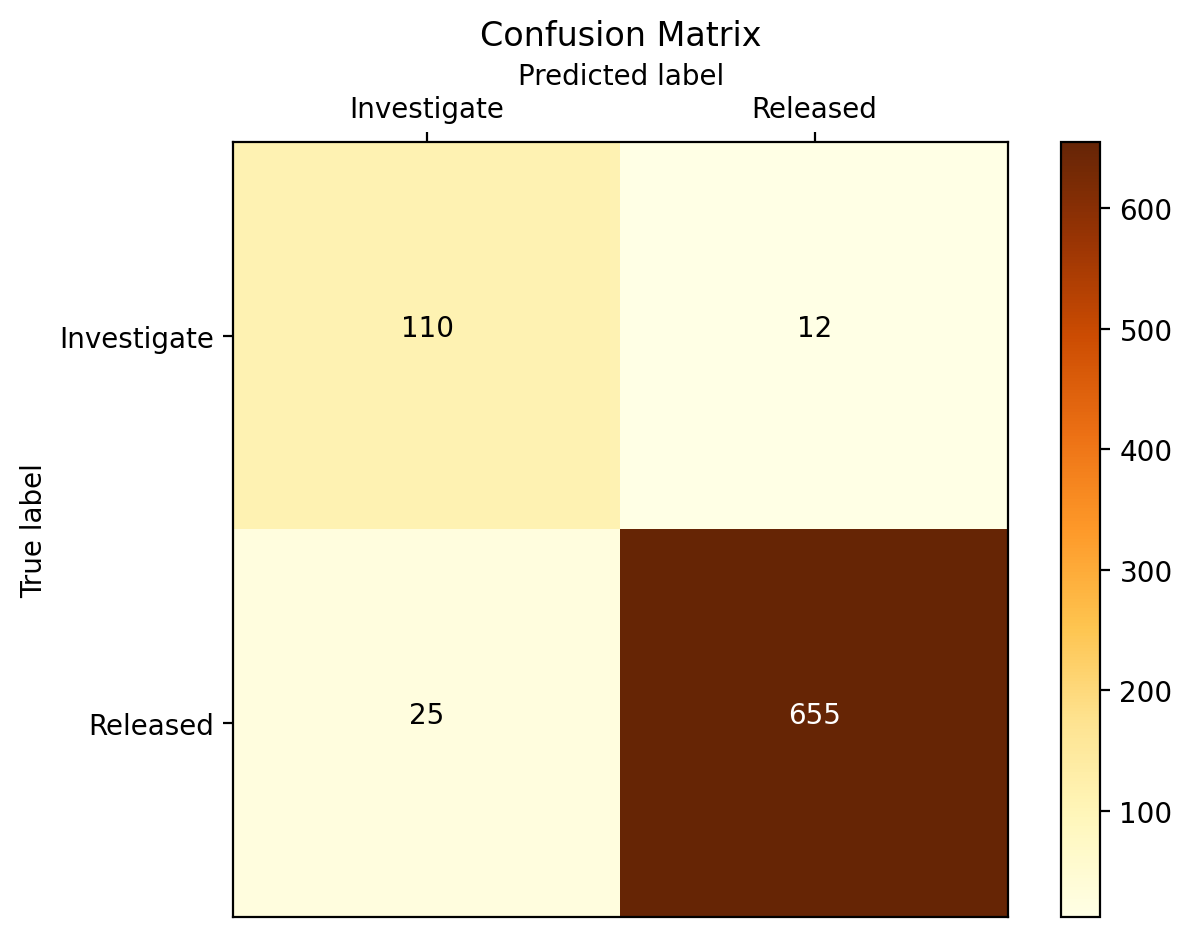

In [13]:
# Best Decision Tree

# Measure fit time
start_fit = time.time()
dt = DecisionTreeClassifier(**best_params_dt, random_state=42)
dt.fit(train, target)
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_pred = time.time()
predicted = dt.predict(test)
dt_results = predicted
end_pred = time.time()
pred_time = end_pred - start_pred

# Metrics
accuracy = metrics.accuracy_score(target_test, predicted)
precision = precision_score(target_test, predicted, pos_label=0)
recall = recall_score(target_test, predicted, pos_label=0)
f1 = f1_score(target_test, predicted, pos_label=0)

# Print Results
print("%-12s %f seconds" % ('Fit Time:', fit_time))
print("%-12s %f seconds" % ('Prediction Time:', pred_time))
print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

dt_metrics = ['Decision Tree', accuracy, precision, recall, f1, fit_time, pred_time]
draw_confusion_matrix(target_test, predicted, ['Investigate', 'Released'])

Fit Time:    0.003955 seconds
Prediction Time: 0.022004 seconds
Test Accuracy: 0.967581
Precision:   0.893443
Recall:      0.893443
F1 Score:    0.893443


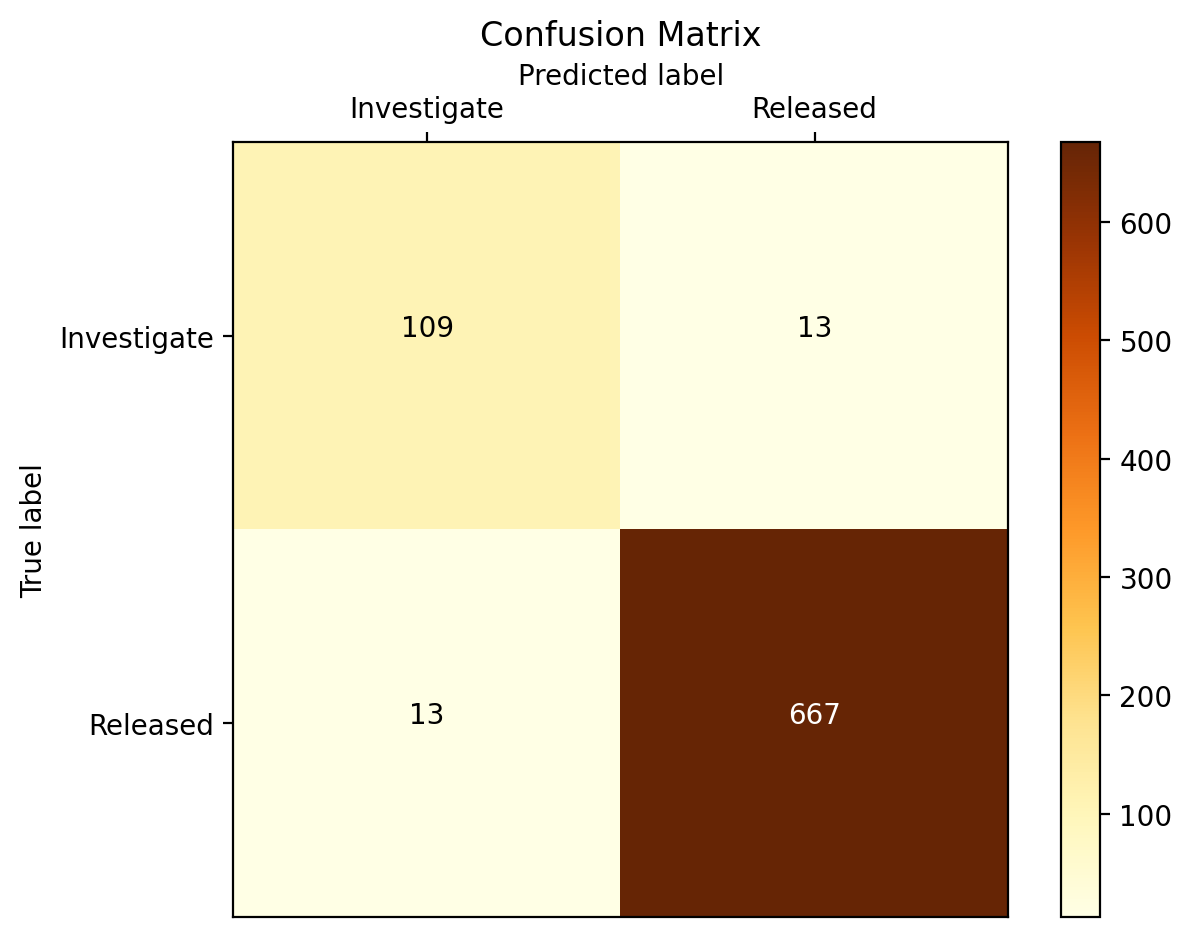

In [14]:
# Best KNN

# Measure fit time
start_fit = time.time()
knn = KNeighborsClassifier(**best_params_knn)
knn.fit(train, target)
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_pred = time.time()
predicted = knn.predict(test)
knn_results = predicted
end_pred = time.time()
pred_time = end_pred - start_pred

# Metrics
accuracy = metrics.accuracy_score(target_test, predicted)
precision = precision_score(target_test, predicted, pos_label=0)
recall = recall_score(target_test, predicted, pos_label=0)
f1 = f1_score(target_test, predicted, pos_label=0)

# Print Results
print("%-12s %f seconds" % ('Fit Time:', fit_time))
print("%-12s %f seconds" % ('Prediction Time:', pred_time))
print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

knn_metrics = ['KNN', accuracy, precision, recall, f1, fit_time, pred_time]
draw_confusion_matrix(target_test, predicted, ['Investigate', 'Released'])

Fit Time:    0.115643 seconds
Prediction Time: 0.002853 seconds
Test Accuracy: 0.967581
Precision:   0.893443
Recall:      0.893443
F1 Score:    0.893443


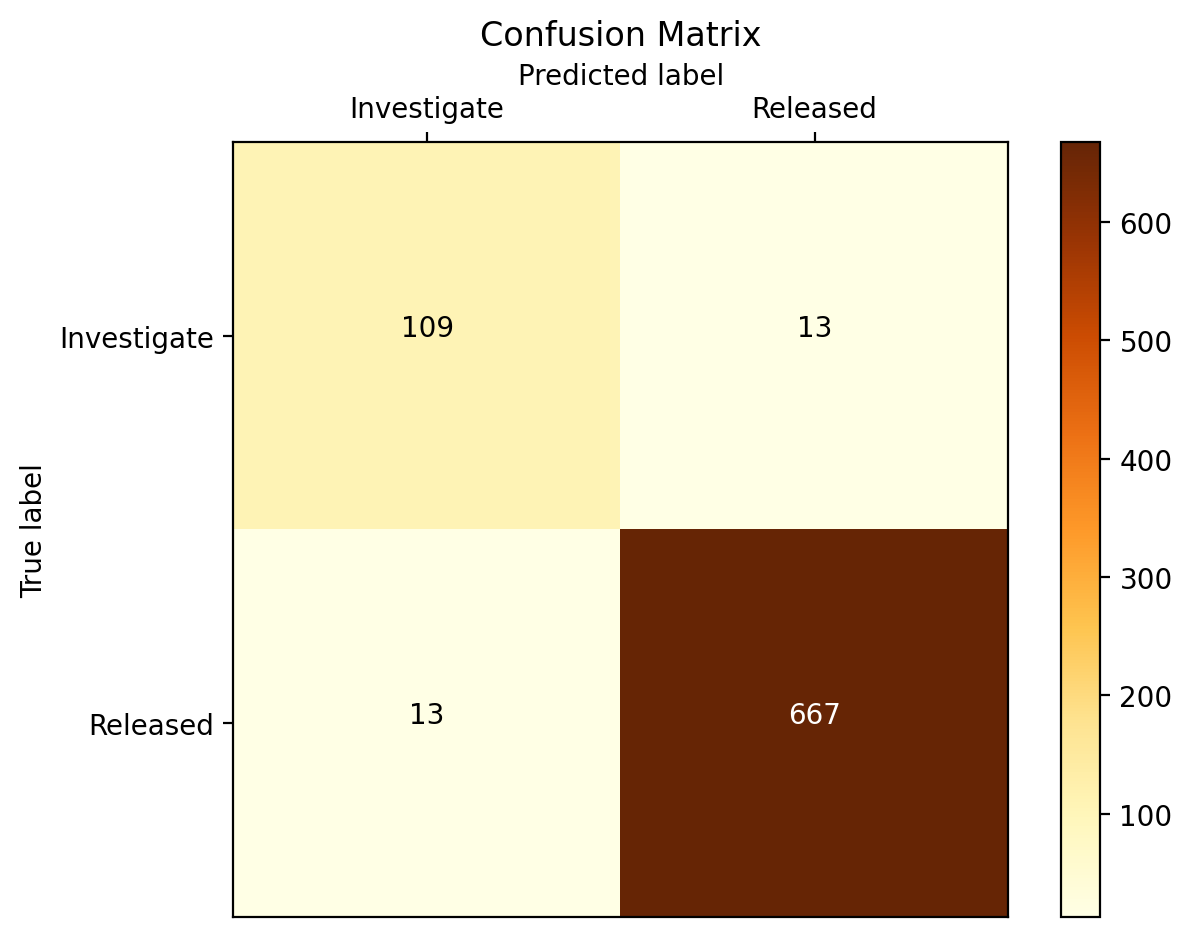

In [ ]:
# Best XGBoost

# Measure fit time
xgb = XGBClassifier(**best_params_xgb, random_state=42)
start_fit = time.time()
xgb.fit(train, target)
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_pred = time.time()
predicted = xgb.predict(test)
xgb_results = predicted
end_pred = time.time()
pred_time = end_pred - start_pred

# Metrics
accuracy = metrics.accuracy_score(target_test, predicted)
precision = precision_score(target_test, predicted, pos_label=0)
recall = recall_score(target_test, predicted, pos_label=0)
f1 = f1_score(target_test, predicted, pos_label=0)

# Print Results
print("%-12s %f seconds" % ('Fit Time:', fit_time))
print("%-12s %f seconds" % ('Prediction Time:', pred_time))
print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

xgb_metrics = ['XGBoost', accuracy, precision, recall, f1, fit_time, pred_time]
draw_confusion_matrix(target_test, predicted, ['Investigate', 'Released'])

[LightGBM] [Info] Number of positive: 1584, number of negative: 285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2781
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.847512 -> initscore=1.715219
[LightGBM] [Info] Start training from score 1.715219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fit Time:    0.591631 seconds
Prediction Time: 0.010698 seconds
Test Accuracy: 0.960100
Precision:   0.862903
Recall:      0.877049
F1 Score:    0.869919


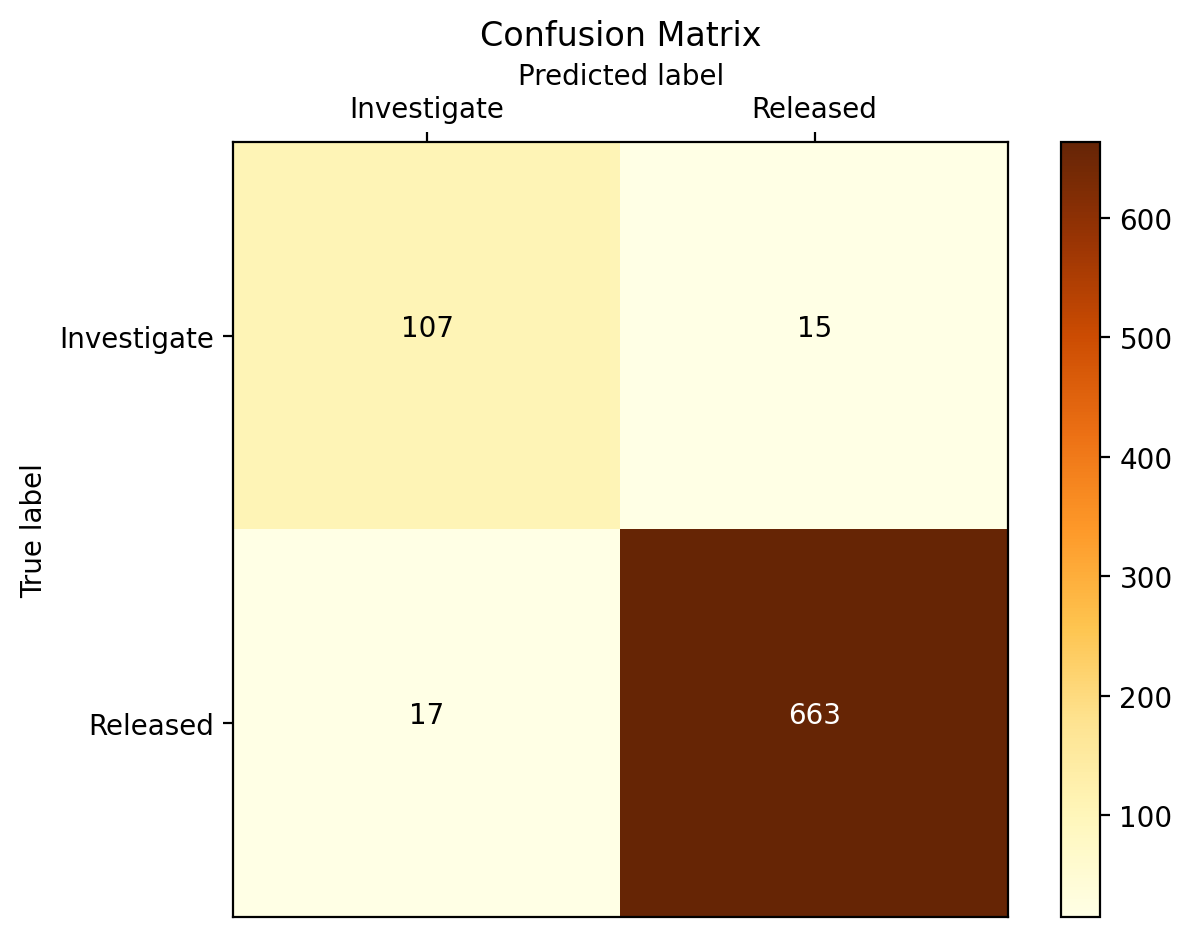

Best LightGBM Parameters:
colsample_bytree: 0.8
learning_rate: 0.1
max_depth: -1
min_child_samples: 10
n_estimators: 300
num_leaves: 100


In [ ]:
# Best LightGBM

# Measure fit time
lgbm = LGBMClassifier(**best_params_lgbm, random_state=42)
start_fit = time.time()
lgbm.fit(train, target)
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_pred = time.time()
predicted = lgbm.predict(test)
lgbm_results = predicted
end_pred = time.time()
pred_time = end_pred - start_pred

# Metrics
accuracy = metrics.accuracy_score(target_test, predicted)
precision = precision_score(target_test, predicted, pos_label=0)
recall = recall_score(target_test, predicted, pos_label=0)
f1 = f1_score(target_test, predicted, pos_label=0)

# Print Results
print("%-12s %f seconds" % ('Fit Time:', fit_time))
print("%-12s %f seconds" % ('Prediction Time:', pred_time))
print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

lgbm_metrics = ['LightGBM', accuracy, precision, recall, f1, fit_time, pred_time]

# Print Best Parameters
print("Best LightGBM Parameters:")
for param, value in best_params_lgbm.items():
    print(f"{param}: {value}")


Fit Time:    0.530070 seconds
Prediction Time: 0.019768 seconds
Test Accuracy: 0.971322
Precision:   0.923077
Recall:      0.885246
F1 Score:    0.903766


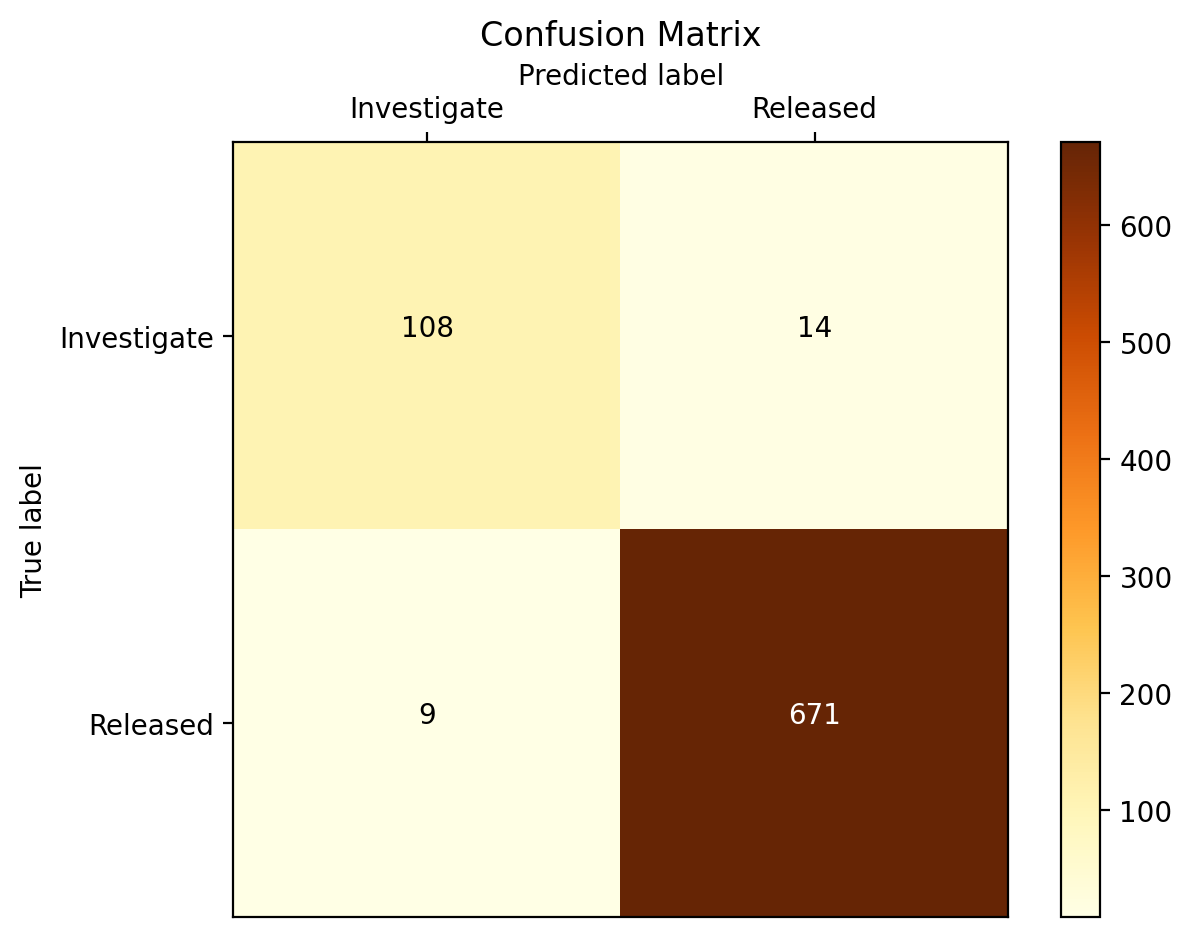

In [ ]:
# Best Random Forest

# Measure fit time
rf = RandomForestClassifier(**best_params_rf, random_state=42)
start_fit = time.time()
rf.fit(train, target)
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_pred = time.time()
predicted = rf.predict(test)
rf_results = predicted
end_pred = time.time()
pred_time = end_pred - start_pred

# Metrics
accuracy = metrics.accuracy_score(target_test, predicted)
precision = precision_score(target_test, predicted, pos_label=0)
recall = recall_score(target_test, predicted, pos_label=0)
f1 = f1_score(target_test, predicted, pos_label=0)

# Print Results
print("%-12s %f seconds" % ('Fit Time:', fit_time))
print("%-12s %f seconds" % ('Prediction Time:', pred_time))
print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

rf_metrics = ['Random Forest', accuracy, precision, recall, f1, fit_time, pred_time]
draw_confusion_matrix(target_test, predicted, ['Investigate', 'Released'])

In [18]:
# Summary Table of Misclassifications
## 1 is Release
## 0 is Investigate

df = pd.DataFrame({
    'XGBoost': xgb_results,
    'LightGBM': lgbm_results,
    'KNN': knn_results,
    'Decision Tree': dt_results,
    'Random Forest': rf_results,
    "Niki Eval": target_test
})

# Only Output Parameters with Incorrect Output
misclassified_summary = df[(df.drop(columns='Niki Eval').ne(df['Niki Eval'], axis=0)).any(axis=1)]
misclassified_summary.index = misclassified_summary.index + 2
print("Summary of Misclassifications:")
print(misclassified_summary.sort_index())
print(misclassified_summary.shape)
misclassified_summary = misclassified_summary.sort_index()

# Exporting Misclassified Entries
misclassified_summary.to_excel("misclassified_summary.xlsx", index=True, engine='xlsxwriter')
print("The misclassified summary has been exported to 'misclassified_summary.csv'.")

Summary of Misclassifications:
      XGBoost  LightGBM  KNN  Decision Tree  Random Forest  Niki Eval
5           1         0    1              0              1          1
13          0         0    0              0              0          1
74          0         0    1              0              0          0
161         1         1    1              1              1          0
164         1         1    1              1              1          0
...       ...       ...  ...            ...            ...        ...
2482        1         0    0              0              0          0
2494        1         1    1              1              1          0
2508        1         1    1              0              1          1
2509        1         1    1              0              1          1
2540        1         1    0              1              1          1

[62 rows x 6 columns]
(62, 6)
The misclassified summary has been exported to 'misclassified_summary.csv'.


Ensemble Accuracy: 0.9688279301745636


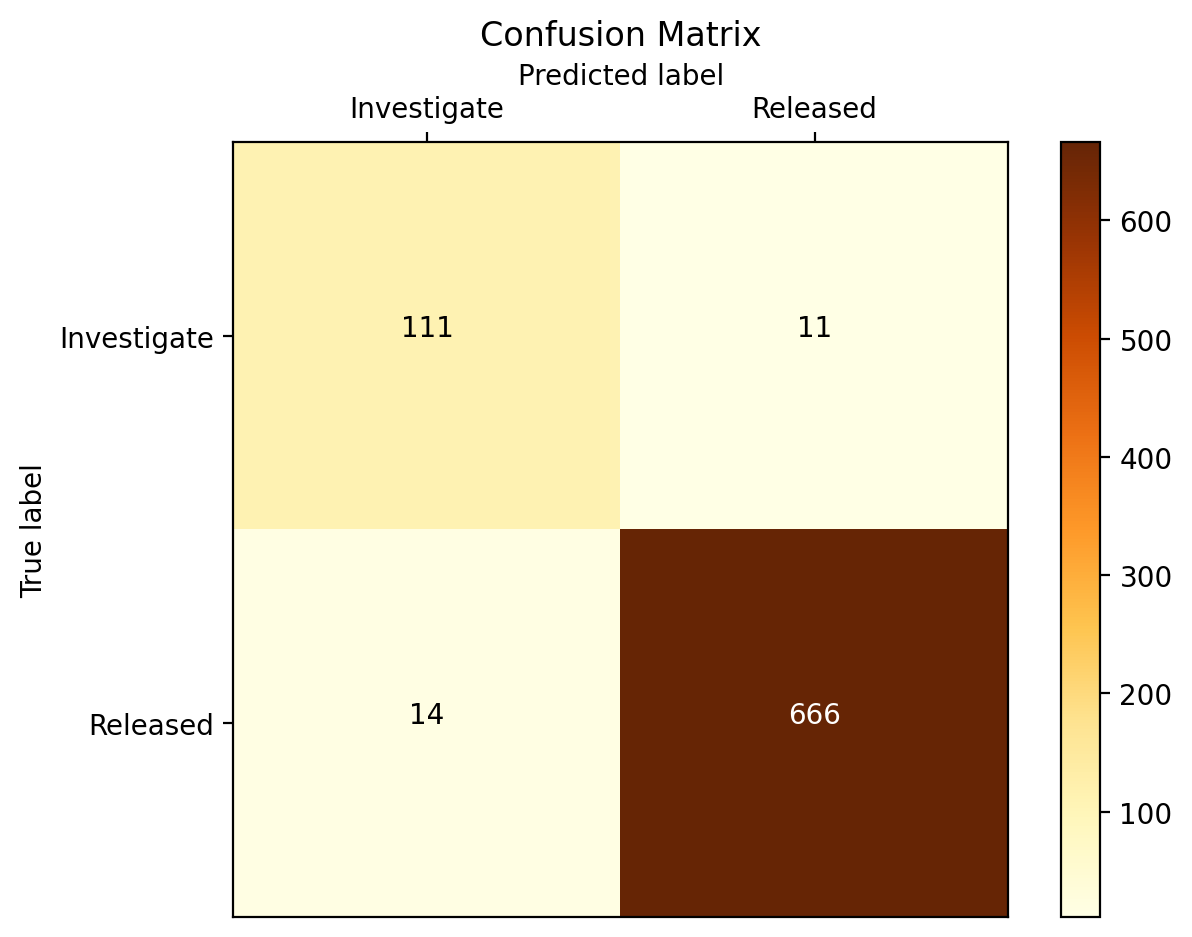

In [ ]:
# Stack all prediction arrays
all_preds = np.vstack([
    xgb_results,
    lgbm_results,
    rf_results,
    dt_results,
])

# Compute row-wise mode to get majority vote
ensemble_results, _ = mode(all_preds, axis=0, keepdims=False)

# Convert to 1D array if needed
ensemble_results = ensemble_results.flatten()

# Evaluate ensemble
print("Ensemble Accuracy:", metrics.accuracy_score(target_test, ensemble_results))
draw_confusion_matrix(target_test, ensemble_results, ['Investigate', 'Released'])

In [ ]:
# Summary Table of All Metrics

all_metrics = [dt_metrics, rf_metrics, xgb_metrics, lgbm_metrics]

# Create a DataFrame
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Fit Time (s)', 'Prediction Time (s)'
])

# Print the table
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
print(metrics_df.to_string(index=False))

        Model  Accuracy  Precision   Recall  F1 Score  Fit Time (s)  Prediction Time (s)
Random Forest  0.971322   0.923077 0.885246  0.903766      0.530070             0.019768
      XGBoost  0.967581   0.893443 0.893443  0.893443      0.115643             0.002853
     LightGBM  0.960100   0.862903 0.877049  0.869919      0.591631             0.010698
Decision Tree  0.953865   0.814815 0.901639  0.856031      0.012142             0.000862
